# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import cohen_kappa_fn, f1_fn
from models import CustomClassifier
from optim_utils import build_optimizer_and_scheduler
from torch import nn
from torchsummary import summary
from torchvision import transforms
from training import Trainer
from visualize import Visualizer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

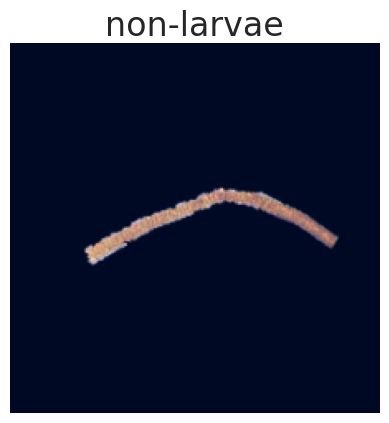

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config = {
    "scheduler": "onecycle",
    "max_lr": 1e-4,
    "lr": 3e-5,
    "eta_min": 1e-7,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN1

In [10]:
cnn_1 = CustomClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 224, 224]             135
       BatchNorm2d-2          [-1, 5, 224, 224]              10
              ReLU-3          [-1, 5, 224, 224]               0
         MaxPool2d-4          [-1, 5, 112, 112]               0
            Conv2d-5          [-1, 5, 224, 224]             375
       BatchNorm2d-6          [-1, 5, 224, 224]              10
              ReLU-7          [-1, 5, 224, 224]               0
         MaxPool2d-8          [-1, 5, 112, 112]               0
            Conv2d-9          [-1, 5, 224, 224]             735
      BatchNorm2d-10          [-1, 5, 224, 224]              10
             ReLU-11          [-1, 5, 224, 224]               0
        MaxPool2d-12          [-1, 5, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           4,320
             ReLU-14         [-1, 32, 1

In [11]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_1 = "weights/larvae-adv-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6903 | Train cohen_kappa_fn: 0.1691 | Val cohen_kappa_fn: 0.0144 | Train f1_fn: 0.8781 | Val f1_fn: 0.8206
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6619 | Val Loss: 0.6802 | Train cohen_kappa_fn: 0.0914 | Val cohen_kappa_fn: 0.1016 | Train f1_fn: 0.3948 | Val f1_fn: 0.4380
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6374 | Val Loss: 0.6598 | Train cohen_kappa_fn: 0.2183 | Val cohen_kappa_fn: 0.2680 | Train f1_fn: 0.7263 | Val f1_fn: 0.7906
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6208 | Val Loss: 0.6375 | Train cohen_kappa_fn: 0.3472 | Val cohen_kappa_fn: 0.2202 | Train f1_fn: 0.8696 | Val f1_fn: 0.9039
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5910 | Val Loss: 0.6051 | Train cohen_kappa_fn: 0.3109 | Val cohen_kappa_fn: 0.3496 | Train f1_fn: 0.7870 | Val f1_fn: 0.8485
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5621 | Val Loss: 0.5735 | Train cohen_kappa_fn: 0.3143 | Val cohen_kappa_fn: 0.4174 | Train f1_fn: 0.7683 | Val f1_fn: 0.8333
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5417 | Val Loss: 0.5426 | Train cohen_kappa_fn: 0.3106 | Val cohen_kappa_fn: 0.4015 | Train f1_fn: 0.7702 | Val f1_fn: 0.8200
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5142 | Val Loss: 0.5056 | Train cohen_kappa_fn: 0.2872 | Val cohen_kappa_fn: 0.3535 | Train f1_fn: 0.7456 | Val f1_fn: 0.7884
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4722 | Val Loss: 0.4774 | Train cohen_kappa_fn: 0.3624 | Val cohen_kappa_fn: 0.4596 | Train f1_fn: 0.8090 | Val f1_fn: 0.8553
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4276 | Val Loss: 0.4382 | Train cohen_kappa_fn: 0.3541 | Val cohen_kappa_fn: 0.4472 | Train f1_fn: 0.7975 | Val f1_fn: 0.8419
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3966 | Val Loss: 0.3996 | Train cohen_kappa_fn: 0.4089 | Val cohen_kappa_fn: 0.4905 | Train f1_fn: 0.8315 | Val f1_fn: 0.8667
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3661 | Val Loss: 0.3694 | Train cohen_kappa_fn: 0.4185 | Val cohen_kappa_fn: 0.5012 | Train f1_fn: 0.8352 | Val f1_fn: 0.8685
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3431 | Val Loss: 0.3480 | Train cohen_kappa_fn: 0.4389 | Val cohen_kappa_fn: 0.4519 | Train f1_fn: 0.8400 | Val f1_fn: 0.8443
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3138 | Val Loss: 0.3511 | Train cohen_kappa_fn: 0.4250 | Val cohen_kappa_fn: 0.3886 | Train f1_fn: 0.8307 | Val f1_fn: 0.8027
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2945 | Val Loss: 0.3007 | Train cohen_kappa_fn: 0.6510 | Val cohen_kappa_fn: 0.5345 | Train f1_fn: 0.9296 | Val f1_fn: 0.8907
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2709 | Val Loss: 0.3533 | Train cohen_kappa_fn: 0.4710 | Val cohen_kappa_fn: 0.3807 | Train f1_fn: 0.8579 | Val f1_fn: 0.7973
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2455 | Val Loss: 0.2602 | Train cohen_kappa_fn: 0.7363 | Val cohen_kappa_fn: 0.6107 | Train f1_fn: 0.9508 | Val f1_fn: 0.9246
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2254 | Val Loss: 0.2701 | Train cohen_kappa_fn: 0.6730 | Val cohen_kappa_fn: 0.5850 | Train f1_fn: 0.9333 | Val f1_fn: 0.9109
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2150 | Val Loss: 0.3068 | Train cohen_kappa_fn: 0.8162 | Val cohen_kappa_fn: 0.7653 | Train f1_fn: 0.9719 | Val f1_fn: 0.9651
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2016 | Val Loss: 0.2475 | Train cohen_kappa_fn: 0.7879 | Val cohen_kappa_fn: 0.6798 | Train f1_fn: 0.9618 | Val f1_fn: 0.9454
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.1920 | Val Loss: 0.3164 | Train cohen_kappa_fn: 0.8270 | Val cohen_kappa_fn: 0.7757 | Train f1_fn: 0.9733 | Val f1_fn: 0.9670
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1657 | Val Loss: 0.2674 | Train cohen_kappa_fn: 0.8319 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9713 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1552 | Val Loss: 0.2188 | Train cohen_kappa_fn: 0.7940 | Val cohen_kappa_fn: 0.7234 | Train f1_fn: 0.9625 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1406 | Val Loss: 0.3020 | Train cohen_kappa_fn: 0.8654 | Val cohen_kappa_fn: 0.7971 | Train f1_fn: 0.9793 | Val f1_fn: 0.9708
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1615 | Val Loss: 0.2084 | Train cohen_kappa_fn: 0.8245 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9688 | Val f1_fn: 0.9526
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1706 | Val Loss: 0.3521 | Train cohen_kappa_fn: 0.8266 | Val cohen_kappa_fn: 0.8194 | Train f1_fn: 0.9742 | Val f1_fn: 0.9745
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1659 | Val Loss: 0.4962 | Train cohen_kappa_fn: 0.7835 | Val cohen_kappa_fn: 0.7222 | Train f1_fn: 0.9702 | Val f1_fn: 0.9642
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1618 | Val Loss: 0.2283 | Train cohen_kappa_fn: 0.6366 | Val cohen_kappa_fn: 0.6380 | Train f1_fn: 0.9191 | Val f1_fn: 0.9203
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1360 | Val Loss: 0.2885 | Train cohen_kappa_fn: 0.8818 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9814 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1318 | Val Loss: 0.1965 | Train cohen_kappa_fn: 0.8436 | Val cohen_kappa_fn: 0.7836 | Train f1_fn: 0.9727 | Val f1_fn: 0.9645
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.1210 | Val Loss: 0.2064 | Train cohen_kappa_fn: 0.8349 | Val cohen_kappa_fn: 0.7645 | Train f1_fn: 0.9712 | Val f1_fn: 0.9606
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1131 | Val Loss: 0.2460 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.8040 | Train f1_fn: 0.9835 | Val f1_fn: 0.9706
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1141 | Val Loss: 0.4130 | Train cohen_kappa_fn: 0.8782 | Val cohen_kappa_fn: 0.7898 | Train f1_fn: 0.9824 | Val f1_fn: 0.9710
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.0902 | Val Loss: 0.6146 | Train cohen_kappa_fn: 0.8237 | Val cohen_kappa_fn: 0.6711 | Train f1_fn: 0.9752 | Val f1_fn: 0.9590
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1333 | Val Loss: 0.2785 | Train cohen_kappa_fn: 0.8947 | Val cohen_kappa_fn: 0.7971 | Train f1_fn: 0.9828 | Val f1_fn: 0.9708
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.0950 | Val Loss: 0.4773 | Train cohen_kappa_fn: 0.9065 | Val cohen_kappa_fn: 0.7705 | Train f1_fn: 0.9860 | Val f1_fn: 0.9694
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.1104 | Val Loss: 0.2296 | Train cohen_kappa_fn: 0.8331 | Val cohen_kappa_fn: 0.7281 | Train f1_fn: 0.9703 | Val f1_fn: 0.9527
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1418 | Val Loss: 0.2102 | Train cohen_kappa_fn: 0.8602 | Val cohen_kappa_fn: 0.7934 | Train f1_fn: 0.9758 | Val f1_fn: 0.9664
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.0981 | Val Loss: 0.2166 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.8313 | Train f1_fn: 0.9842 | Val f1_fn: 0.9742
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.0894 | Val Loss: 0.2442 | Train cohen_kappa_fn: 0.8983 | Val cohen_kappa_fn: 0.8341 | Train f1_fn: 0.9836 | Val f1_fn: 0.9741
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


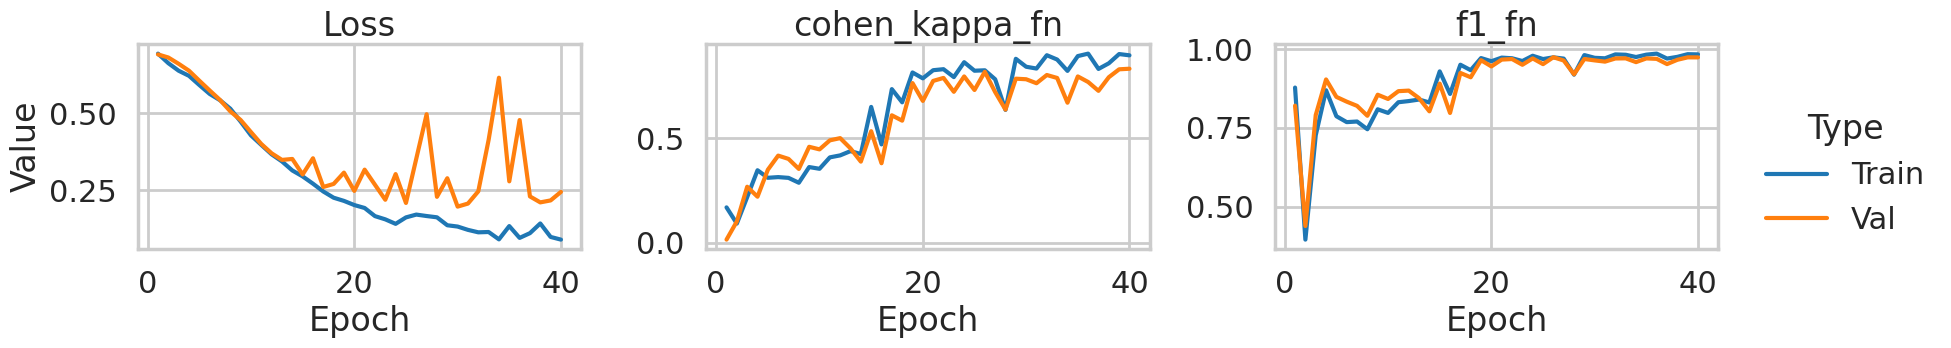

In [13]:
trainer_cnn_1.plot_epochs()

In [14]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1504 | Test cohen_kappa_fn: 0.8623 | Test f1_fn: 0.9776


#### Visualization

In [15]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

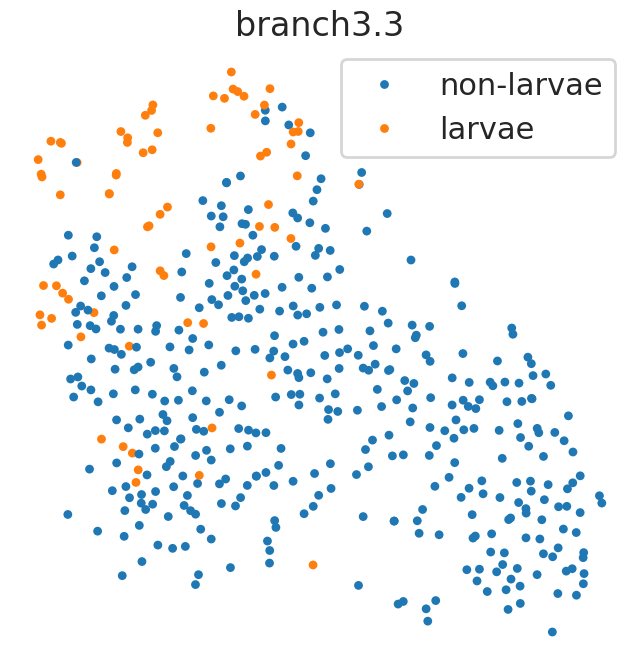

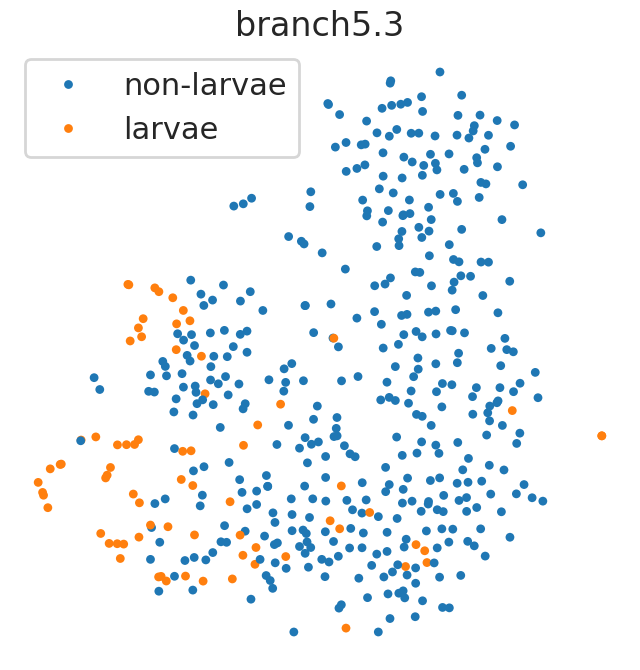

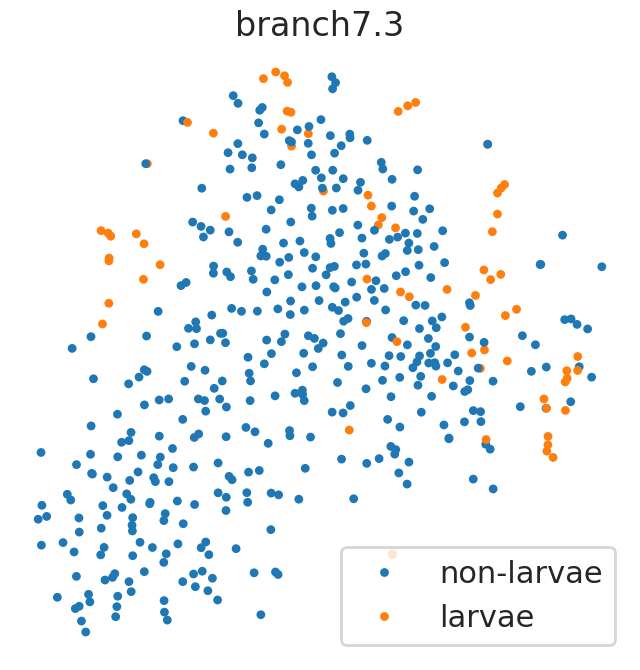

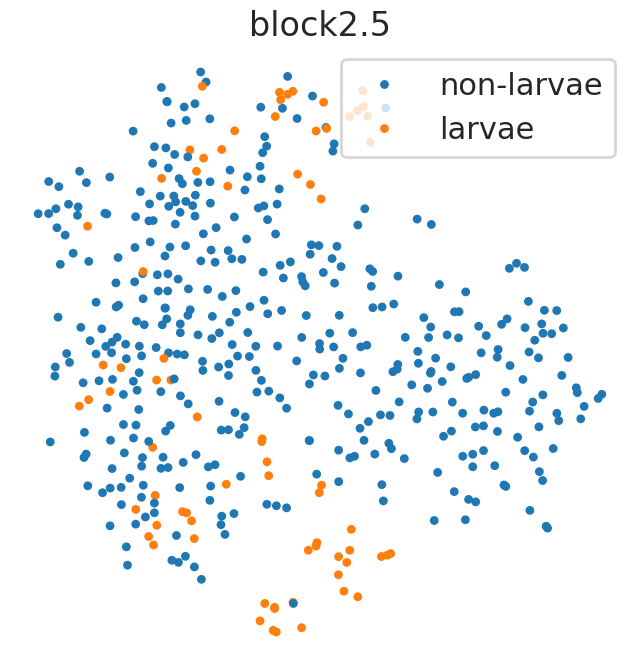

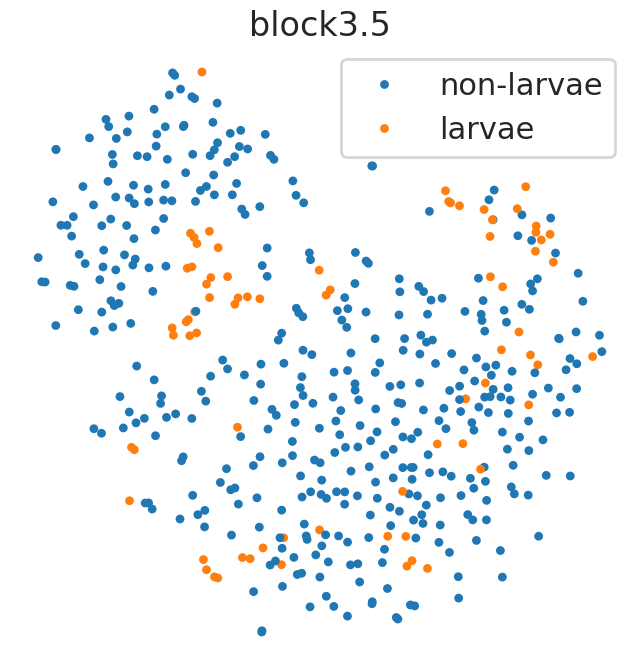

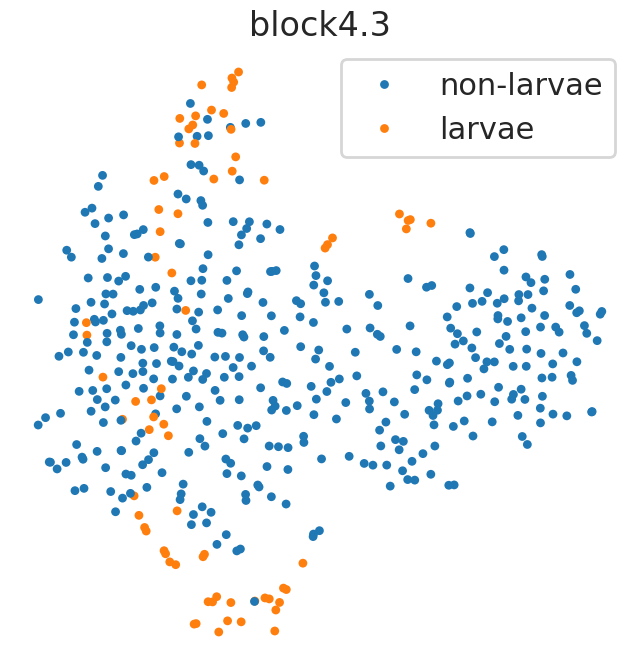

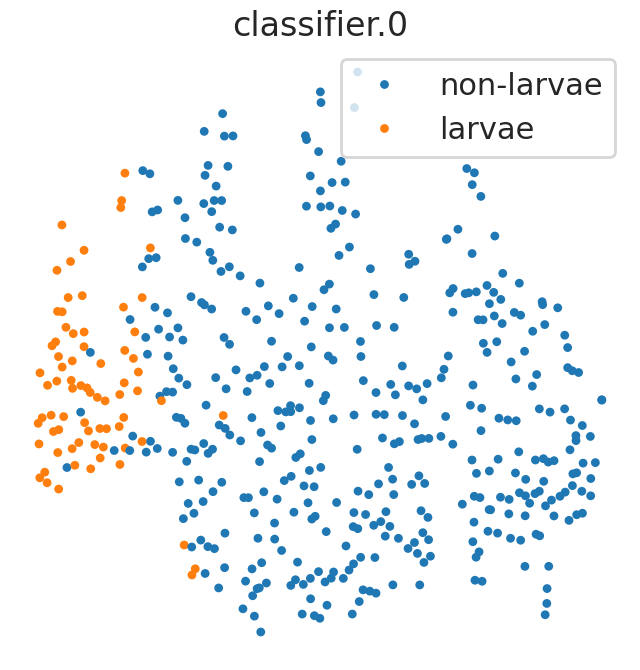

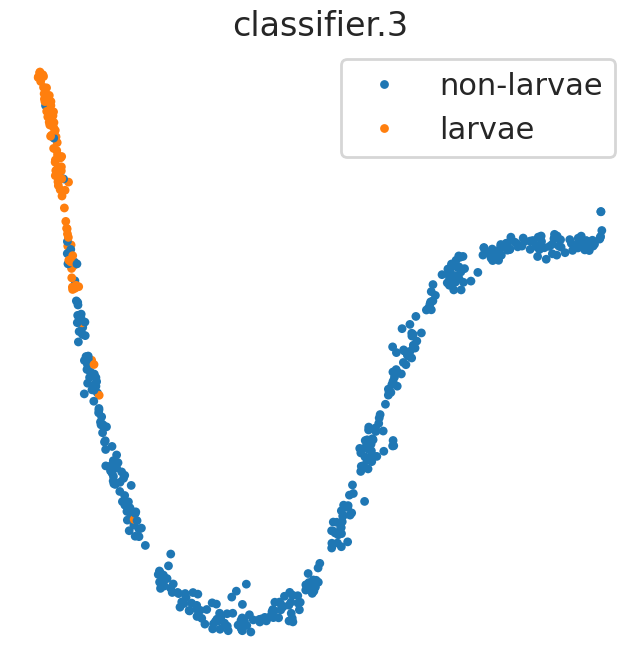

In [16]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


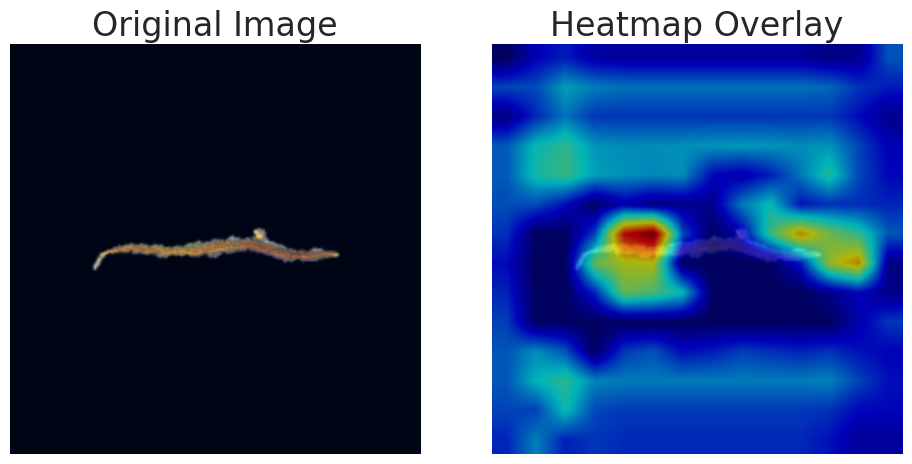

  Generating heatmap for Larvae...
  Predicted label is Larvae!


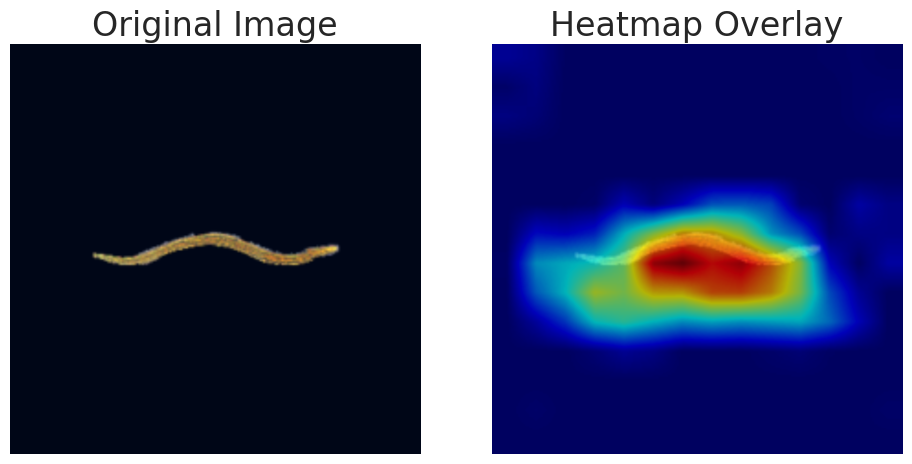

In [18]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break